Download and pre-process the _20 NewsGroup_ dataset.

In [1]:
import re
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pasquale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pasquale/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')


In [3]:
data.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [4]:
data.groupby('target_names').count()

,content,target
target_names,,
alt.atheism,480,480
comp.graphics,584,584
comp.os.ms-windows.misc,591,591
comp.sys.ibm.pc.hardware,590,590
comp.sys.mac.hardware,578,578
comp.windows.x,593,593
misc.forsale,585,585
rec.autos,594,594
rec.motorcycles,598,598


The dataset appear somehow balanced among classes.

In [5]:
lem = nltk.stem.WordNetLemmatizer()
email_regex = r'([a-z0-9_-]+\.)*[a-z0-9_-]+@[a-z0-9_-]+(\.[a-z0-9_-]+)*\.[a-z]{2,6}'

def prepare_text(text):
    text = text.lower()
    text = re.sub('from:.+\n', '', text)
    text = re.sub('article-i\.d\.:.+\n', '', text)
    text = re.sub('nntp-posting-host:.+\n', '', text)
    text = re.sub('organization:.+\n', '', text)
    text = re.sub('x-newsreader:.+\n', '', text)
    text = re.sub('distribution:.+\n', '', text)
    text = re.sub('reply-to:.+\n', '', text)
    text = re.sub('from article <.+>.+\n', '', text)
    text = re.sub('in article <.+>.+\n', '', text)
    text = re.sub('<.+>', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.split('=======')[0]
    text = re.sub(email_regex, '', text)
    text = re.sub('[^\s]+@[^\s]+.+\n', '', text)

    text = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(text)
    text = [w for w in text if w != 'lines']
    text = [lem.lemmatize(w) for w in text]
    text = [w for w in text if not(w in ['from', 'subject', 'edu', 'use', 'ke'] or w in nltk.corpus.stopwords.words('english')) and len(w)>=3 and '_' not in w]
    text = [w for w in text if len(w)>=3]
    return text

In [6]:
data['content'] = data.content.apply(lambda x: prepare_text(x))

In [7]:
with open('../data/20ng.txt', 'w') as f:
     for d in data['content']:
            f.write(' '.join(d))
            f.write('\n')

In [8]:
with open('../data/20ng_labels.txt', 'w') as f:
     for d in data['target_names']:
            f.write(d)
            f.write('\n')

## Some stats

In [9]:
import numpy as np
import gensim
import matplotlib.pyplot as plt

In [10]:
data_words = data['content'].values

In [11]:
id2word = gensim.corpora.Dictionary(data_words)

corpus = [id2word.doc2bow(text) for text in data_words]

Dimension of the dataset

In [12]:
len(data_words)


11314

Average number of word per document

In [13]:
np.mean([len(d) for d in data_words])

125.58281774792293

Distribution of first 50 words

In [14]:
token_tf = [(id2word[token_id],freq) for token_id, freq in id2word.cfs.items()]
token_tf.sort(key=lambda x: x[1], reverse = True)

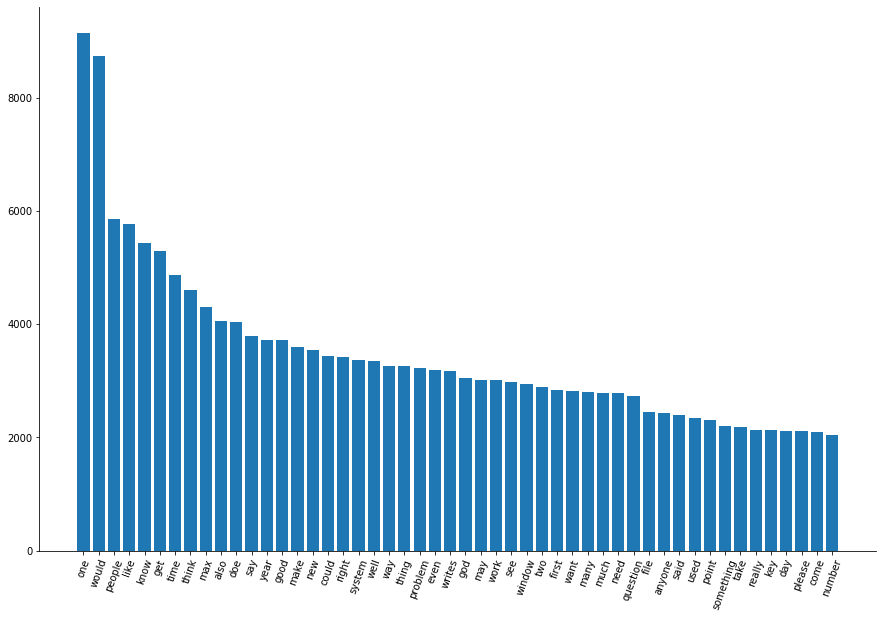

In [15]:
fig, ax = plt.subplots(figsize = (15,10))

plt.bar(*zip(*token_tf[:50]))

ax.tick_params(axis='x', rotation=70)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('20ng_word_distribution.pdf')  